# Evolution of the L1Topo hdw-sim
<hr style="border-top-width: 4px; border-top-color: #34609b;">
This simple notebook shows the evolution over time of the agreement between hardware and simulation of the ATLAS L1Topological triggers.

In [10]:
%matplotlib inline
import ROOT as R

In order to activate the interactive visualisation we can use the [JSROOT](https://root.cern.ch/js/) magic:

In [11]:
%jsroot on

In [12]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

In [13]:
import numpy as np

Read the files produced by the script `plot_2d_split_by_algo.py`

In [14]:
import glob
input_filenames = glob.glob('../l1topo/hdw-sim/*.root')
print "Processing %d input files" % len(input_filenames)

Processing 159 input files


In [15]:
import os
def commonPrefix(lst) : return os.path.commonprefix(lst)
def commonSuffix(lst) : return os.path.commonprefix([l[::-1] for l in lst])[::-1]

class InputRootFile(object):
    "hold the input filename and try to guess the run number"
    def __init__(self, filename):
        self.path = filename
        self.run_number = None
        self.lines = []
    def guess_run(self, prefix='', suffix='', verbose=False):
        run_candidate = self.path[len(prefix):-len(suffix)]
        if run_candidate.isdigit():
            self.run_number = int(run_candidate)
            if verbose:
                print "run %d : %s" % (self.run_number, self.path)
        elif verbose:
            print "cannot guess run number for '%s' with pre='%s', suf='%s'" % (self.path,
                                                                                prefix,
                                                                                suffix)
        return self
    def parse_lines(self, verbose=False):
        'in fact here just reading bins'
        input_file = R.TFile.Open(self.path)
        histo = input_file.Get('false_negative')
        self.lines = [HdwSimBin(histo, bin) for bin in range(1, 1+histo.GetNbinsX())]
        input_file.Close()
        return self

class HdwSimBin(object):
    "an HdwSimLine entry for an algo, extracted from a bin, i.e. values are with error"
    def __init__(self, histo, bin):
        self.line = ''
        # see formatting in plot_2d_split_by_algo.py:
        h = histo
        self.algo_name = h.GetXaxis().GetBinLabel(bin)
        self.frac_hdw_not_sim = float(h.GetBinContent(bin, 1))
        self.frac_sim_not_hdw = float(h.GetBinContent(bin, 2))
        self.frac_hdw_not_sim_err = float(h.GetBinError(bin, 1))
        self.frac_sim_not_hdw_err = float(h.GetBinError(bin, 2))
        self.counts_hdw = int(h.GetBinContent(bin, 3))
        self.counts_sim = int(h.GetBinContent(bin, 4))


In [16]:
prefix='../l1topo/hdw-sim/'
suffix='.root'
input_files = [InputRootFile(f).guess_run(prefix=prefix, suffix=suffix).parse_lines() for f in input_filenames]
guessed_all_runs = all(f.run_number for f in input_files)
if guessed_all_runs:
    input_files.sort(key=lambda f: f.run_number)
else:
    print "cannot guess all run numbers, using input order"
all_algos = list(set(l.algo_name for f in input_files for l in f.lines))
# print all_algos # debug

In [17]:
class AlgoEvolution(object):
    "track the evolution of the hdw-sim agreement for an algo"
    def __init__(self, name='', input_files=[]):
        self.algoname = name
        self.input_files = input_files
        self.lines = [next((l for l in inf.lines if l.algo_name==self.algoname),
                           None) # keep lists in sync: 'None' for missing lines                                                                                                                             
                      for inf in input_files]
        self.variation_indices = []
        missing_runs = [inf.run_number for inf, line in zip(input_files, self.lines)
                        if line is None]
        some_missing = self.lines.count(None)>0
        if some_missing:
            print "%s has %d missing runs...cannot detect changes yet" % (self.algoname,
                                                                          self.lines.count(None))
        # read the data series and normalize it
        self.hns = np.array([l.frac_hdw_not_sim for l in self.lines])
        self.hns_mean = np.mean(self.hns)
        self.hns_median = np.median(self.hns)
        self.hns_rms = np.std(self.hns)
        self.hns_norm = (self.hns-self.hns_median)/(self.hns_rms if self.hns_rms else 1.0)
        self.snh = np.array([l.frac_sim_not_hdw for l in self.lines])
        self.snh_mean = np.mean(self.snh)
        self.snh_median = np.median(self.snh)
        self.snh_rms = np.std(self.snh)
        self.snh_norm = (self.snh-self.snh_median)/(self.snh_rms if self.snh_rms else 1.0)
        selfhnse = np.array([l.frac_hdw_not_sim_err for l in self.lines])
        self.snhe = np.array([l.frac_sim_not_hdw_err for l in self.lines])
        self.runs = np.array([inf.run_number for inf, l in zip(self.input_files, self.lines)])
        

algos_history = [AlgoEvolution(name=an, input_files=input_files)
                 for an in all_algos]


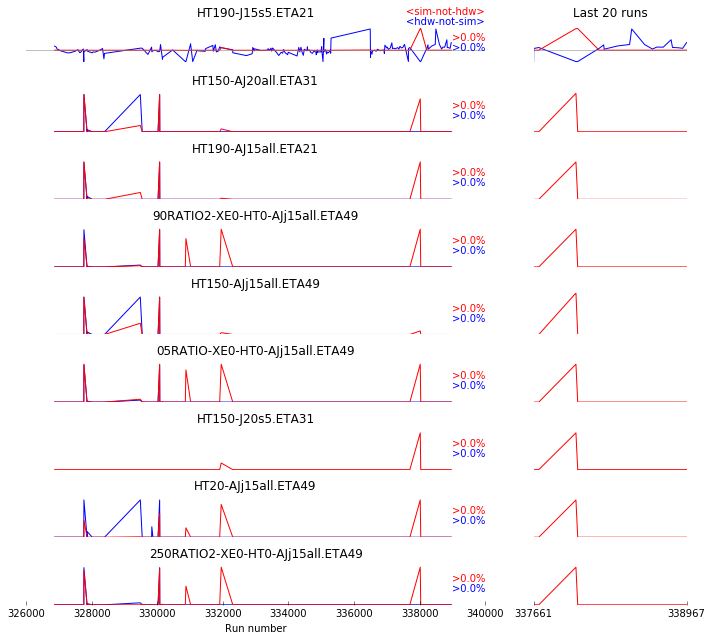

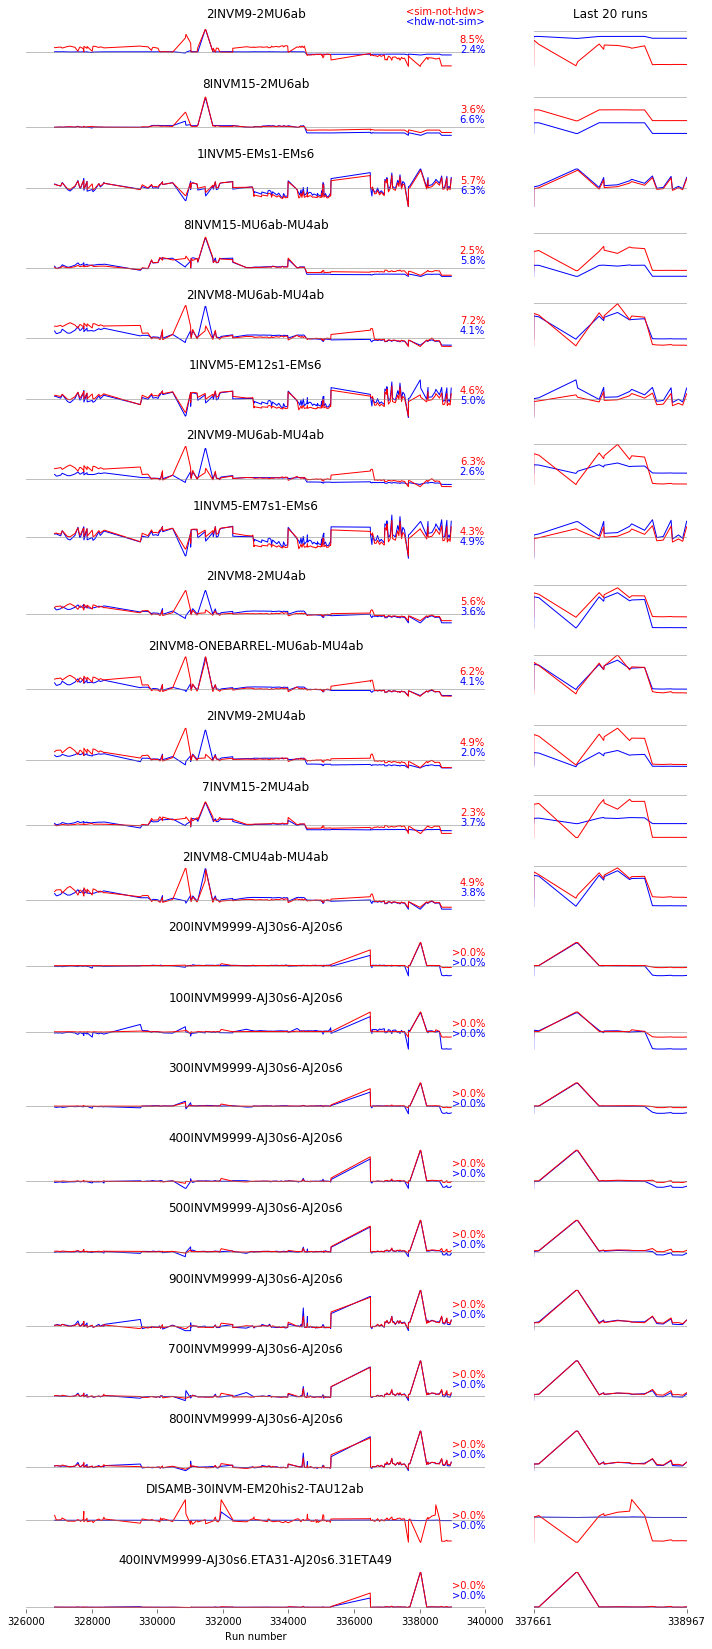

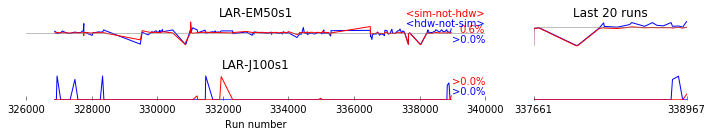

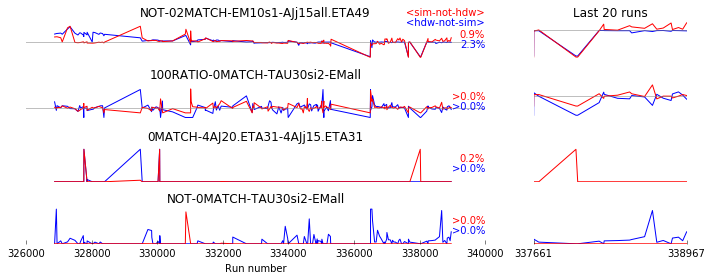

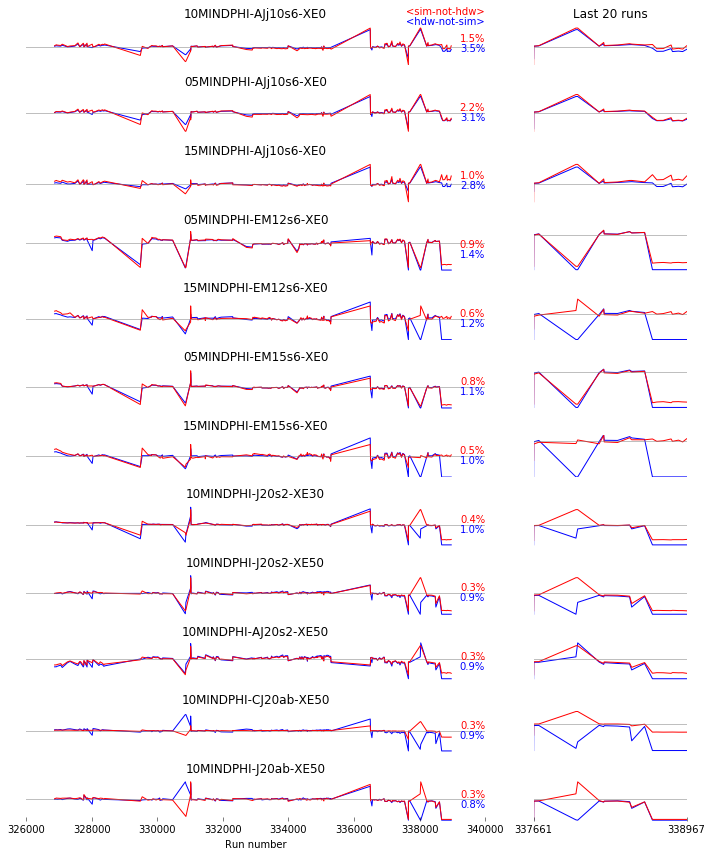

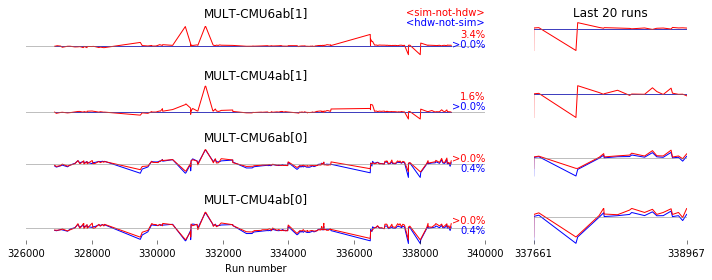

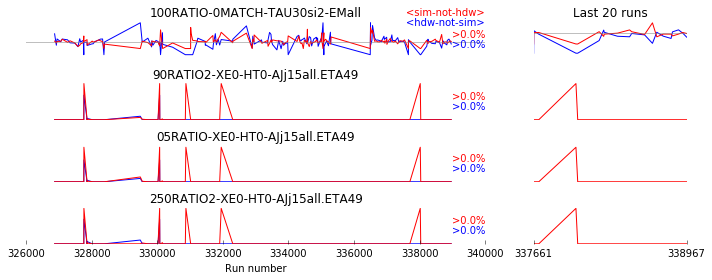

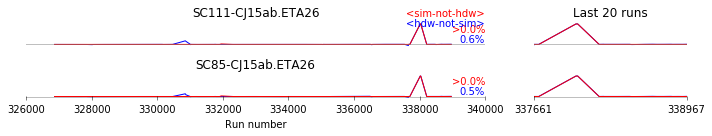

In [18]:
def replace_outliers(data, nsigma=3.0):
    "outliers can hide actual trends; replace them with thresholds"
    mean = np.mean(data)
    rms = np.std(data)
    upper_threshold = mean+nsigma*rms
    lower_threshold = mean-nsigma*rms
    data[data > upper_threshold] = upper_threshold
    data[data < lower_threshold] = lower_threshold
    return data
algonames = ['DETA','DISAMB','DPHI','DR','HT','INVM','KF','LAR','MATCH','MINDPHI','MT','MULT','RATIO','SC']
algoname = 'INVM'
#algoname = 'KF'
for algoname in algonames:
    algos = sorted([a for a in algos_history if algoname in a.algoname],
                    key=lambda _ : max([abs(_.hns_median), abs(_.snh_median)]),
                   reverse=True) # algos with the largest discrepancy at the top
    runs = algos[0].runs
    last_n = 20 # plot the last N runs in a zoom-in on the right column
    runs10 = algos[0].runs[-last_n:]
    fig = plt.figure(figsize=(10, len(algos)))
    gs = matplotlib.gridspec.GridSpec(len(algos), 2, width_ratios=[3, 1]) 
    hns_plotopt = {'linestyle':'-', 'color':'b'} # 'color':'b','markerstyle':'3', 'markeredgecolor':'b'
    snh_plotopt = {'linestyle':'-', 'color':'r'} # 'color':'r','markerstyle':'4', 'markeredgecolor':'b'
    # left column
    ax1 = fig.add_subplot(gs[0]) # nrows, ncols, plot_number, top sparkline
    ax1.plot(runs, replace_outliers(algos[0].hns_norm), **hns_plotopt)
    ax1.plot(runs, replace_outliers(algos[0].snh_norm), **snh_plotopt)

    ax1.axhline(c='grey', alpha=0.5)

    axesl = []
    for i, al in enumerate(algos[1:]):
        ax = fig.add_subplot(gs[2*(i+1)], sharex=ax1) 
        ax.plot(runs, replace_outliers(al.hns_norm), **hns_plotopt)
        ax.plot(runs, replace_outliers(al.snh_norm), **snh_plotopt)
        ax.axhline(c='grey', alpha=0.5)
        axesl.append(ax)

    # right column
    ax2 = fig.add_subplot(gs[1])
    ax2.get_xaxis().get_major_formatter().set_useOffset(False)
    ax2.set_xticks([runs10[0], runs10[-1]])
    ax2.plot(runs10, algos[0].hns_norm[-last_n:], **hns_plotopt)
    ax2.plot(runs10, algos[0].snh_norm[-last_n:], **snh_plotopt)
    ax2.axhline(c='grey', alpha=0.5)
    axesr = []
    for i, al in enumerate(algos[1:]):
        ax = fig.add_subplot(gs[2*(i+1)+1], sharex=ax2)
        ax.plot(runs10, al.hns_norm[-last_n:], **hns_plotopt)
        ax.plot(runs10, al.snh_norm[-last_n:], **snh_plotopt)
        ax.axhline(c='grey', alpha=0.5)
        axesr.append(ax)

    # adjust graphics
    for axl,axr, al in zip([ax1]+axesl, [ax2]+axesr, algos): # remove all borders
        axl.set_title(al.algoname)
        plt.setp(axl.get_xticklabels(), visible=False)
        plt.setp(axl.get_yticklabels(), visible=False)
        plt.setp(axl.get_xticklines(), visible=False)
        plt.setp(axl.get_yticklines(), visible=False)
        plt.setp(axl.spines.values(), visible=False)
        plt.setp(axr.get_xticklabels(), visible=False)
        plt.setp(axr.get_yticklabels(), visible=False)
        plt.setp(axr.get_xticklines(), visible=False)
        plt.setp(axr.get_yticklines(), visible=False)
        plt.setp(axr.spines.values(), visible=False)
    
        left, width = .25, .5
        bottom, height = .25, .5
        right = 1.0 #left + 2*width
        top = bottom + height

        axl.text(right, 0.5*(bottom+top),"%s%.1f%%" % ('>' if al.hns_mean<1.e-3 else '', 100.*al.hns_mean),
                horizontalalignment='right',
                verticalalignment='top',
                color='blue',
                transform=axl.transAxes)
        axl.text(right, 0.5*(bottom+top),"%s%.1f%%" % ('>' if al.snh_mean<1.e-3 else '', 100.*al.snh_mean),
                horizontalalignment='right',
                verticalalignment='bottom',
                color='red',
                transform=axl.transAxes)
        if axl!=ax1:
            continue
        axl.text(right, 1.5*top,"<hdw-not-sim>",
                horizontalalignment='right',
                verticalalignment='top',
                color='blue',
                transform=axl.transAxes)
        axl.text(right, 1.5*top,"<sim-not-hdw>",
                horizontalalignment='right',
                verticalalignment='bottom',
                color='red',
                transform=axl.transAxes)
        axr.set_title("Last %d runs" % last_n)


    # bottom sparklines
    axbl = axesl[-1]
    plt.setp(axbl.get_xticklabels(), visible=True)
    plt.setp(axbl.get_xticklines(), visible=True)
    axbl.xaxis.tick_bottom() # but onlyt the lower x ticks not x ticks at the top
    axbl.set_xlabel('Run number')
    axbr = axesr[-1]
    plt.setp(axbr.get_xticklabels(), visible=True)
    plt.setp(axbr.get_xticklines(), visible=True)
    axbr.xaxis.tick_bottom() # but onlyt the lower x ticks not x ticks at the top

    plt.tight_layout()
    #plt.show()
    plt.savefig(algoname+'.pdf')
    plt.savefig(algoname+'.png')
